In [2]:
from py2neo import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "dbms"))

__ANALISI DEL DATASET__

__Numero di film per utente__

In [22]:
movies_per_user_count = pd.DataFrame(
    graph.run(
        (
            "MATCH(u:User)-[h:RATES]->(m:Movie)"
            "RETURN u.id as ID, count(*) AS COUNT"
        )
    ).data()
)

movies_per_user_count.sort_values(by="COUNT", ascending=False).head()

,ID,COUNT
31813,71e1599b-ab75-44c1-9667-1ca41fae6c06,32202
28693,220ac93a-1d6d-484f-9030-cfbda6ce1212,9178
9007,a5ef5a66-8586-4ba1-90b7-72510d060630,8913
45339,55e46524-926d-4343-8513-6b452794837c,7919
50246,79e268ec-800c-470e-8d55-f8cf7502ae6b,7488


Come possiamo vedere dalle statistiche sotto, il numero di film per utente è abbastanza stabile e contenuto (una __media__ di __153.8__ con __deviazione standard__ __268__). C'è un outlier (l'utente con 32.202 recensioni), ma per tutti gli altri ci si mantiene sotto il migliaio: nel complesso le query che da un singolo utente chiedono i film recensiti __non__ dovrebbero rappresentare un problema eccessivo in termini di tempo di computazione.

In [8]:
movies_per_user_count.sort_values(by="COUNT", ascending=False).describe()

,COUNT
count,162541.000000
mean,153.807925
std,268.047589
min,20.000000
25%,36.000000
50%,71.000000
75%,162.000000
max,32202.000000


__Numero di utenti per film__

In [24]:
user_per_movie_count = pd.DataFrame(
    graph.run(
        (
            "MATCH(u:User)-[h:RATES]->(m:Movie)"
            "RETURN m.id as ID, m.title as TITLE, count(*) AS COUNT"
        )
    ).data()
)

user_per_movie_count.sort_values(by="COUNT", ascending=False).head()

,ID,TITLE,COUNT
351,a251e83e-49f0-4a70-ba0c-0cc77ce23a8a,Forrest Gump,81491
314,b30eb0f4-790d-4ba0-8e7b-796f2b1d7534,"Shawshank Redemption, The",81482
292,9501228f-c2f2-402b-9b6c-402ff7fd1f58,Pulp Fiction,79672
585,b71a26ee-41f5-4151-828e-fb54028c9201,"Silence of the Lambs, The",74127
2480,333ea22d-cfd4-48a1-964e-45631cdc3cdd,"Matrix, The",72674


Al contrario, il numero di utenti per film è molto più __instabile__, e tocca valori molto più __alti__ (per i film particolarmente __famosi__, as esempio _Forrest Gump_ e _Pulp function_). Ci aspettiamo, dunque, maggiori latenze per ricavare gli utenti che hanno visto alcuni film e le loro recensioni. 

In [9]:
user_per_movie_count.describe()

,COUNT
count,59047.000000
mean,423.393128
std,2477.885797
min,1.000000
25%,2.000000
50%,6.000000
75%,36.000000
max,81491.000000


__Numero di film per genere__

Il numero di generi per film è naturalmente limitato dalla cardinalità dell'insieme dei generi, mentre il numero di film per genere viene rappresentato nel grafo sotto. Ci aspettiamo di poter avere tempi di latenza maggiori per i due generi più attribuiti, ovvero __Drama (7)__ e __Comedy (4)__.

Text(0, 0.5, 'number of movies')

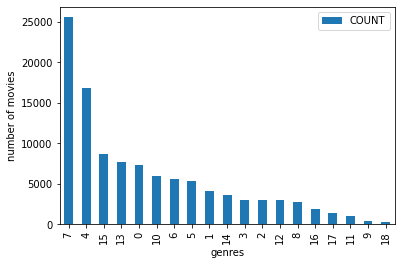

In [10]:
genre_count = pd.DataFrame(
    graph.run(
        (
            "MATCH(g:Genre)<-[h:HAS_GENRE]-(m:Movie)"
            "RETURN g.id as ID, g.name as GENRE, count(*) AS COUNT"
        )
    ).data()
)

genre_count.sort_values(by=["COUNT"], ascending=False).plot.bar()
plt.xlabel("genres")
plt.ylabel("number of movies")

Nel dataset originale, ogni film è associato a ognuna delle __1128 categorie__ e ogni categoria è associata a ogni film, con un certo score. Per ragioni di computazione e di convenienza (ci interessano solo le categorie rilevanti), ho inserito nel database solamente le associazioni con score __score $\geq$ 0.4__.

__Numero di film per categoria__

In [25]:
movies_per_category_count = pd.DataFrame(
    graph.run(
        (
            "MATCH(c:Category)-[d:DESCRIBES]->(m:Movie)"
            "RETURN c.name as CATEGORY, count(*) AS COUNT"
        )
    ).data()
)

movies_per_category_count.sort_values(by=["COUNT"], ascending=False)

,CATEGORY,COUNT
741,original,13816
187,catastrophe,13136
645,mentor,11850
467,great ending,9240
866,runaway,7961
...,...,...
1029,tolkien,8
488,hannibal lecter,7
391,figure skating,7
697,neil gaiman,4


__Numero categorie per film__

Anche se filtrare le categorie porta a una notevole riduzione delle associazioni di film per categoria, possiamo vedere che (similmente a quanto avveniva per i generi) il numero di categorie per film è notevolmente minore del numero di film per categoria.

In [26]:
categories_per_movie_count = pd.DataFrame(
    graph.run(
        (
            "MATCH(c:Category)-[d:DESCRIBES]->(m:Movie)"
            "RETURN m.id as ID, m.title as TITLE, count(*) AS COUNT"
        )
    ).data()
)

categories_per_movie_count.sort_values(by=["COUNT"], ascending=False)

,ID,TITLE,COUNT
2075,76ee3232-bd79-4095-adf4-4276bc97dbe3,Passchendaele,421
127,86615b9f-1c50-4107-aadb-1044d81be60c,Welcome to Dongmakgol,358
430,fba6b450-87c2-4db8-ab35-b2d5c186ca73,Drunk Stoned Brilliant Dead: The Story of the ...,333
1979,691551fb-650f-4b57-a114-8bd196c23352,"Band Called Death, A",332
2252,0dafe9c9-bf3f-4a5a-9bc2-aa9cb3419471,Death Rides a Horse (Da uomo a uomo),328
...,...,...,...
13720,b7efb1ed-2327-449a-9c23-ebcb3d3400ad,"Alarmist, The (a.k.a. Life During Wartime)",7
13668,6f4eefa5-8245-41fe-b98d-dad030a4c501,Happy Together,6
13542,f9367d77-c40b-4215-87fd-51ae401b0086,Home Again,6
13614,fb0502fc-cb07-4e14-b0da-e9fdcdd9cb02,House of Angels (Änglagård),4


__Query 1__: Ottienere i __top k generi__, dato un utente.

In [8]:
user_id = "d34f66d3-8ee4-40bf-a37e-7856ec99ef83"
graph.run(
    (
        "MATCH(u:User)-[r:RATES]->(m:Movie)-[h:HAS_GENRE]->(g:Genre)"
        f"WHERE u.id = '{user_id}'"
        "RETURN g.name as GENRE, AVG(r.score) as AVG_SCORE "
        "ORDER BY AVG_SCORE DESC "
        "LIMIT 5"
    )
).to_table()


GENRE,AVG_SCORE
Western,3.6
Romance,3.0526315789473686
Thriller,2.9333333333333327
Sci-Fi,2.9183673469387754
Comedy,2.899999999999999


In [11]:
user_id = "71e1599b-ab75-44c1-9667-1ca41fae6c06"
graph.run(
    (
        "MATCH(u:User)-[r:RATES]->(m:Movie)-[h:HAS_GENRE]->(g:Genre) "
        f"WHERE u.id = '{user_id}' "
        "RETURN g.name as GENRE, MAX(r.score)*COUNT(r.score) as SCORE "
        "ORDER BY SCORE DESC "
        "LIMIT 5"
    )
).to_table()


GENRE,SCORE
Drama,82425
Comedy,39615
Thriller,21940
Romance,21290
Action,15950


Get __top k categories__, given a __user__ 

In [12]:
graph.run(
    (
        "MATCH(u:User)-[r:RATES]->(m:Movie)<-[d:DESCRIBES]-(c:Category) "
        f"WHERE u.id = '{user_id}' "
        "RETURN c.name as CATEGORY, AVG(d.relevance) as SCORE "
        "ORDER BY SCORE DESC "
        "LIMIT 5"
    )
).to_table()


CATEGORY,SCORE
emma watson,0.958657894736842
beatles,0.9568392857142857
star trek,0.9426666666666667
batman,0.9395625
vampires,0.9223377192982455


Get __top k movies__, given a __genre__ (movies related to a genre, group by movie, get avg rating)
Better if we take the maximum count, MOST POPULAR

In [16]:
genre_id = "6c14fe55-df99-44bb-9bcd-00c8ebf448aa"
graph.run(
    (
        f"MATCH(g:Genre{{id: '{genre_id}'}})<-[h:HAS_GENRE]-(m:Movie)<-[r:RATES]-(u:User)"
        "RETURN m.title as MOVIE, avg(r.score) as SCORE "
        "ORDER BY SCORE DESC "
        "LIMIT 10"
    )
).to_table()


MOVIE,SCORE
"Pericles, Prince of Tyre",5.0
The Ultimate Legacy,5.0
Claire Darling,5.0
Kabir Singh,5.0
All's Well That Ends Well: Shakespeare's Globe Theatre,5.0
The Merchant of Venice,5.0
The Parting Glass,5.0
Pariyerum Perumal,5.0
Zana,5.0
Oblivion Verses,5.0


In [31]:
genre_id = "c16401e5-a5e0-466d-aaef-898e442c3f45"	

graph.run(
    (
        f"MATCH(g:Genre{{id: '{genre_id}' }})<-[h:HAS_GENRE]-(m:Movie)<-[r:RATES]-(u:User) "
        "RETURN m.title as MOVIE, count(r.score) as SCORE "
        "ORDER BY SCORE DESC "
        "LIMIT 5"
    )
).to_table()


MOVIE,SCORE
Pulp Fiction,79672
"Silence of the Lambs, The",74127
"Matrix, The",72674
Jurassic Park,64144
Fight Club,58773


In [32]:
graph.run(
    (
        f"MATCH(g:Genre{{id: '{genre_id}'}})<-[h:HAS_GENRE]-(m:Movie)<-[r:RATES]-(u:User)"
        "RETURN m.title as MOVIE, count(r.score)*max(r.score) as SCORE "
        "ORDER BY SCORE DESC "
        "LIMIT 5"
    )
).to_table()


MOVIE,SCORE
Pulp Fiction,398360
"Silence of the Lambs, The",370635
"Matrix, The",363370
Jurassic Park,320720
Fight Club,293865


In [21]:
genre_count.sort_values(by=["COUNT"], ascending=False)

,ID,GENRE,COUNT
7,6c14fe55-df99-44bb-9bcd-00c8ebf448aa,Drama,25606
4,a53a6565-a03b-4774-a1ae-1e8c02ed0445,Comedy,16870
15,c16401e5-a5e0-466d-aaef-898e442c3f45,Thriller,8654
13,3e9de744-f6f7-4e3c-a749-109be8526c11,Romance,7719
0,2159b9b5-f29f-4002-815a-2c78223aa206,Action,7348
10,bf37e52e-9ca9-437a-b6c9-d0049230380e,Horror,5989
6,c5f2b690-f5d9-42f9-850f-458f9abe0a6e,Documentary,5605
5,7c12d04f-7404-4fd1-8223-293898565985,Crime,5319
1,98a3b7e1-ed0f-4e9d-abb2-7f47e235c143,Adventure,4145
14,281500a9-4d3a-47ee-9e6f-ef376dece738,Sci-Fi,3595


Get __top k movies__, given a __category__ (highest scores with category)

In [9]:
category_count = pd.DataFrame(
    graph.run(
        (
            "MATCH(c:Category)-[d:DESCRIBES]-(m:Movie)"
            "RETURN c.id as ID, c.name as CATEGORY, count(*) AS COUNT"
        )
    ).data()
)

category_count.sort_values(by=["COUNT"], ascending=False).describe()


,COUNT
count,1128.000000
mean,853.917553
std,1296.324007
min,1.000000
25%,140.750000
50%,375.000000
75%,1028.750000
max,13816.000000


In [34]:
category_id = "8b94d2c2-822e-4d3b-87f3-a58cc21c9f21"
graph.run(
    (
        f"MATCH(c:Category{{id: '{category_id}'}})-[d:DESCRIBES]->(m:Movie)"
        "RETURN m.title as MOVIE, d.relevance as RELEVANCE "
        "ORDER BY RELEVANCE DESC "
        "LIMIT 5"
    )
).to_table()


MOVIE,RELEVANCE
Hulk,0.999
"Punisher, The",0.99875
Hellboy,0.9985
Fantastic Four,0.9985
X-Men,0.9985


COULD PROBABILY USE THE PRE-COMPUTED PATTERN or REDUCE CATEGORIES UNDER A THRESHOLD

In [36]:
category_id = "8a1b259b-dbd5-493b-aead-68714b73a7db"
graph.run(
    (
        f"MATCH(c:Category{{id: '{category_id}'}})-[d:DESCRIBES]->(m:Movie)<-[r:RATES]-(u:User)"
        "RETURN m.title as MOVIE, d.relevance*avg(r.score) as POP_RELEVANCE "
        "ORDER BY POP_RELEVANCE DESC "
        "LIMIT 5"
    )
).to_table()


MOVIE,POP_RELEVANCE
Three Colors: Red (Trois couleurs: Rouge),3.9300705582317903
Persona,3.8807999999999976
Vertigo,3.877729444967085
"Third Man, The",3.8737327981651486
"Conversation, The",3.840662105495477


#### __USER BASED CF__

In [37]:
"""
CALL gds.graph.project(
  'movie_recommendations_cf',                                
  ["User", "Movie", "Genre", "Category"],  
  [
  {
    HAS_GENRE: {orientation: "UNDIRECTED"}
  },
  {
    RATES : { properties: "score", orientation: "UNDIRECTED"}
  },
  {
    DESCRIBES : { properties: "relevance", orientation: "UNDIRECTED"}
  } 
  ]                
)
YIELD
  graphName, nodeProjection, nodeCount AS nodes, relationshipCount AS rels
RETURN graphName, nodeProjection.Book AS bookProjection, nodes, rels
"""

'\nCALL gds.graph.project(\n  \'movies_recommendations\',                                \n  ["User", "Movie", "Genre", "Category"],  \n  ["HAS_GENRE",                  \n  {\n    RATES : { properties: "score"}\n  },\n  {\n    DESCRIBES : { properties: "relevance"}\n  }\n  ]                       \n)\nYIELD\n  graphName, nodeProjection, nodeCount AS nodes, relationshipCount AS rels\nRETURN graphName, nodeProjection.Book AS bookProjection, nodes, rels\n'

In [ ]:
"""
CALL gds.fastRP.mutate('movie_recommendations_cf',
  {
    nodeLabels: ["User", "Movie"],
    relationshipTypes: ["RATES"],
    embeddingDimension: 256,
    relationshipWeightProperty: 'score',
    randomSeed: 42,
    mutateProperty: 'embedding'    
  }
)
YIELD nodePropertiesWritten
"""


In [ ]:
"""
CALL gds.fastRP.stream('movie_recommendations_cf',
  {
    nodeLabels: ["User", "Movie"],
    relationshipTypes: ["RATES"],
    embeddingDimension: 256,
    relationshipWeightProperty: 'score',
    randomSeed: 42
  }
)
YIELD nodeId, embedding
"""

In [ ]:
"""
CALL gds.graph.writeNodeProperties('movie_recommendations_cf', ['embedding'], ['User'])
YIELD propertiesWritten
"""

In [ ]:
"""
CALL gds.graph.project(
  'cf-projection',  
  {
      User: {properties : "embedding"}
  },   
    ["*"]                      
)
YIELD
  graphName, nodeProjection, nodeCount AS nodes, relationshipCount AS rels
RETURN graphName, nodeProjection.Book AS bookProjection, nodes, rels
"""

In [ ]:
"""
CALL gds.knn.stream(
  "cf-projection",
  {   
      nodeProperties: ["embedding"]
  }
) YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).id AS User1, gds.util.asNode(node2).id AS User2, similarity
ORDER BY similarity DESCENDING, User1, User2
"""

In [ ]:
"""
CALL gds.knn.write('cf-projection', {
    nodeProperties: ["embedding"],
    writeRelationshipType: 'SIMILAR',
    writeProperty: 'score',
    topK: 10,
    nodeProperties: ['embedding']
})
YIELD nodesCompared, relationshipsWritten
"""

Get __similar users__, given a __user__

In [35]:
user_id = "71e1599b-ab75-44c1-9667-1ca41fae6c06"
graph.run(
            (
            f"MATCH (u1:User{{id: '{user_id}'}})-[s:SIMILAR]->(u2:User)"
            " RETURN u2.id AS ID, s.score AS SCORE"
            " ORDER BY SCORE DESC"
            )
        ).to_table()

ID,SCORE
6242c722-4e0e-4db3-80a3-a03b8b1cb2ba,0.9114094972610474
ac3188f8-03a7-4ab8-a906-ef4dae488f9d,0.908204197883606
a5ef5a66-8586-4ba1-90b7-72510d060630,0.903659999370575
954c1fbd-2790-4d65-9622-987511eb5c04,0.8815503120422363
4a8856f0-5d4e-4d17-b1e2-5c567b8ae139,0.8736069202423096
b8766815-c30c-416b-8ebb-eee37f22865e,0.8730874061584473
fb5bb7b3-1c75-4238-9c04-88e6ed443b3b,0.8679203987121582
2e6a8a5c-5a15-4912-a842-2daff9b99303,0.8675627708435059
da95806c-2365-4b69-b4f6-7a9b62e777b9,0.8667223453521729
bd22c54a-5139-4d4a-bab9-54f4e6855ecf,0.8662257790565491


Recommending movies from __similar users__, given a __user__ (collaborative filtering)

In [37]:
user_id = "71e1599b-ab75-44c1-9667-1ca41fae6c06"

graph.run(
    (
        f"MATCH(u:User {{id: '{user_id}'}})-[:RATES]->(m:Movie) "
        "WITH collect(m.id) AS watchedMoviesIds "
        f"MATCH (u1:User{{id: '{user_id}'}})-[s:SIMILAR]->(u2:User)-[r:RATES]->(m:Movie) "
        "WHERE NOT m.id IN watchedMoviesIds "
        "RETURN m.id as ID, m.title as TITLE, r.score*s.score AS SCORE "
        "ORDER BY SCORE DESC "
        "LIMIT 10"
    )
).to_table()


ID,TITLE,SCORE
e8672bfe-d802-4580-96fa-dabe603a903d,Vergeef,4.54102098941803
5885bdd3-99f6-41c8-a9b1-c95af10b9f0f,The Cookie Carnival,4.407751560211182
a0f42a32-e313-46c4-b3ca-1015e8619eb2,The Fox in the Chicken Coop,4.368034601211548
3b60b1ee-ddd1-4b29-b1ef-9f011f7b6ea8,Extinct Pink,4.368034601211548
a184518b-d17a-4444-aa1e-2417b7975aa9,La Parmigiana,4.368034601211548
ebffde54-3815-4668-ac04-01fed3ff8861,The Unfaithfuls,4.368034601211548
8b380cee-cb7d-47af-ad85-f29dc6ee862f,The Castaways of Turtle Island,4.368034601211548
cd631d6c-4bb6-4fc4-afbf-c2d9bb771b0b,Ha! Ha! Ha!,4.368034601211548
0ae632c2-f7b2-4fe9-aa6b-e3e7afa92dbb,The Scavengers,4.368034601211548
6f555b3c-4783-48e3-bbf1-0a81e2ee0eb3,A Lustful Man,4.368034601211548


#### __CONTENT BASED CF__

In [ ]:
"""
CALL gds.graph.project.cypher(
  'movie_recommendations_cb',
  'MATCH (n) WHERE n:Movie OR n:Genre OR n:Category RETURN id(n) AS id, labels(n) AS labels',
  'MATCH (n)-[r:DESCRIBES|HAS_GENRE]-(m) RETURN id(n) AS source, id(m) AS target, type(r) AS type, coalesce(r.relevance, 1.0) AS relevance'    
)   
YIELD
  graphName AS graph, nodeCount AS nodes, relationshipCount AS rels 
"""


In [ ]:
"""
CALL gds.fastRP.mutate('movie_recommendations_cb',
  {
    nodeLabels: ["Movie", "Genre", "Category"],
    relationshipTypes: ["HAS_GENRE", "DESCRIBES"],
    embeddingDimension: 256,
    randomSeed: 42,
    mutateProperty: 'embedding'    
    relationshipWeightProperty: 'relevance',
    
  }
)
YIELD nodePropertiesWritten
"""


In [ ]:
"""
CALL gds.graph.writeNodeProperties('movie_recommendations_cb', ['embedding'], ['Movie'])
YIELD propertiesWritten
"""

In [ ]:
"""
CALL gds.graph.project(
  'cb-projection',  
  {
      Movie : {properties : "embedding"}
  },   
    ["*"]                      
)
YIELD
  graphName, nodeProjection, nodeCount AS nodes, relationshipCount AS rels
RETURN graphName, nodeProjection.Book AS bookProjection, nodes, rels
"""

In [ ]:
"""
CALL gds.knn.stream(
  "cb-projection",
  {   
      nodeProperties: ["embedding"]
  }
) YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).id AS Movie1, gds.util.asNode(node2).id AS Movie2, similarity
ORDER BY similarity DESCENDING, Movie1, Movie2
"""

In [ ]:
"""
CALL gds.knn.write('cb-projection', {
    nodeProperties: ["embedding"],
    writeRelationshipType: 'SIMILAR',
    writeProperty: 'score',
    topK: 10,
    nodeProperties: ['embedding']
})
YIELD nodesCompared, relationshipsWritten
"""

Get __similar movies__, given a movie

In [11]:
movie_id = "0b142bcb-3bcb-4ce7-943e-b73b16cf4f15"
graph.run(
    (
        f"MATCH (m1:Movie{{id: '{movie_id}'}})-[s:SIMILAR]->(m2:Movie) "
        "RETURN m2.id AS ID, m2.title AS TITLE, s.score AS SIMILARITY "
        "ORDER BY SIMILARITY DESC "
    )
).to_table()

ID,TITLE,SIMILARITY
0dafe9c9-bf3f-4a5a-9bc2-aa9cb3419471,Death Rides a Horse (Da uomo a uomo),0.9952797889709473
06054ec4-fdbd-49c4-8fbf-03acd206db3d,Parasite,0.9951488971710205
d5d4d59e-aadf-4d1b-995a-77d32b39d25f,Old Boy,0.9937421083450317
ab10a271-44a5-4352-b03d-f87b195cb60c,Ghost in the Shell Arise - Border 3: Ghost Tears,0.9936655163764954
836e7227-12b1-4215-a6e8-04d5a0e33500,Nightcrawler,0.9936624765396118
527f1a8d-fc9b-48bf-baee-81e6ab846b9c,Memento,0.9936578273773193
691551fb-650f-4b57-a114-8bd196c23352,"Band Called Death, A",0.993545651435852
9501228f-c2f2-402b-9b6c-402ff7fd1f58,Pulp Fiction,0.9934476613998413
41b6d0e2-695d-4eb6-a813-6f67ba664fc9,"Thing: Terror Takes Shape, The",0.9933952689170837
352a1319-54df-4b50-bbcd-c1a59b67a6f2,Blade Runner 2049,0.993350625038147


 Recommending __similar movies__

In [6]:
user_id = "85cd6e98-63a7-4445-9342-85c2a5628be6"

graph.run(
    (   f"MATCH(u:User {{id: '{user_id}'}})-[:RATES]->(m:Movie) "
        "WITH collect(m.id) AS watchedMoviesIds "
        f"MATCH (u:User{{id: '{user_id}'}})-[r:RATES]->(m1:Movie)-[s:SIMILAR]->(m2:Movie) "
        "WHERE NOT m2.id IN watchedMoviesIds "
        "RETURN m2.id AS ID , m2.title AS TITLE, s.score*r.score AS SCORE "
        "ORDER BY SCORE DESC "
        "LIMIT 10"
    )
).to_table()

ID,TITLE,SCORE
7ce39604-1646-44c1-8ac6-8ea31b9a8084,"Pianist, The",4.992698431015015
5f210d5a-f719-48b7-a388-de6e21b3d781,Blue Planet II,4.97689962387085
e79cfc9a-f881-42a3-9daf-84ef2c776f20,Misery,4.9765545129776
68b0af18-162a-4111-b282-60555570d482,"Green Mile, The",4.9761658906936646
cbf03f03-037e-4b76-8fab-74a18f36c95a,Seven (a.k.a. Se7en),4.975505769252777
81f3f3d5-8d2c-4b2c-8a4c-0b8c773750fa,12 Years a Slave,4.97529149055481
cff9c910-4b33-4461-80e0-69ec1bd3d91d,Dear Zachary: A Letter to a Son About His Father,4.9745529890060425
f8b83362-5876-46dc-9168-cac41bc65def,Cosmos: A Spacetime,4.9743252992630005
29aae105-8c06-465c-9588-f24c091e93f0,Runaway Jury,4.974263310432434
34eeffd8-d5a6-4ae6-a6d3-94064fbd5f48,Slumdog Millionaire,4.974065721035004
